In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 95.9 MB/s eta 0:00:00


In [ ]:
import os
import json
import tempfile
import shutil

import torch
torch.backends.cudnn.benchmark = True  # Enable cuDNN autotuner for performance
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import PIL

from monai.config import print_config
from monai.utils import set_determinism
#from monai.apps import download_and_extract  # if you ever need sample data
from monai.transforms import (
    Compose, LoadImage, EnsureChannelFirst, ScaleIntensity,
    RandRotate, RandFlip, RandZoom,
    Activations, AsDiscrete, Resize, Lambda, ThresholdIntensity, SobelGradients
)
from monai.data import DataLoader, decollate_batch
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121

print_config()

MONAI version: 1.6.dev2524
Numpy version: 2.0.2
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 1be81d981f92f8fa2fb1c27dfe5dad8c2e371624
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.15.3
Pillow version: 11.2.1
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.52.4
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io

In [ ]:
IMAGE_DIR      = "/content/images"
METADATA_FILE  = "/content/metadata.json"
SEED           = 0
BATCH_SIZE     = 64
MAX_EPOCHS     = 1
LR             = 1e-5
VAL_INTERVAL   = 1

In [ ]:
set_determinism(seed=SEED)

In [ ]:
with open(METADATA_FILE, "r") as f:
    metadata = json.load(f)

image_paths = []
labels      = []
for entry in metadata:
    img_path = os.path.join(IMAGE_DIR, f"{entry['image_id']}.jpg")
    if not os.path.exists(img_path):
        continue
    image_paths.append(img_path)
    # 1 if aneurysm key present; else 0
    labels.append(int(bool(entry.get("anomalies", {}).get("aneurysm"))))

total_images = len(image_paths)
print(f"Found {total_images} images")

Found 500 images


In [ ]:
indices = np.arange(total_images)
np.random.shuffle(indices)
test_split = int(0.1 * total_images)
val_split  = int(0.1 * total_images) + test_split

test_idx  = indices[:test_split]
val_idx   = indices[test_split:val_split]
train_idx = indices[val_split:]

train_x = [image_paths[i] for i in train_idx]
train_y = [labels[i]      for i in train_idx]
val_x   = [image_paths[i] for i in val_idx]
val_y   = [labels[i]      for i in val_idx]
test_x  = [image_paths[i] for i in test_idx]
test_y  = [labels[i]      for i in test_idx]

print(f"Train: {len(train_x)}, Val: {len(val_x)}, Test: {len(test_x)}")

Train: 400, Val: 50, Test: 50


In [ ]:
train_transforms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    ScaleIntensity(),#normalize pixels
    Resize(spatial_size=(244, 244)),
    Lambda(lambda x: x[:1]), #reduce to one channel
    RandRotate(range_x=np.pi/12, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    #SobelGradients(spatial_axes=0)
    ThresholdIntensity(threshold = 0.55),
    #ThresholdIntensity(threshold = 0.5, above = True, cval = 0)
])

val_transforms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    ScaleIntensity(),
    Resize(spatial_size=(244, 244)),
    Lambda(lambda x: x[:1]),
    #SobelGradients(spatial_axes=0)
    #ThresholdIntensity(threshold = 0.4),
        #ThresholdIntensity(threshold = 0.5, above = True, cval = 0)
])

post_pred = Compose([Activations(softmax=True)])
post_label = Compose([AsDiscrete(to_onehot=2)])

In [ ]:
class AneurysmDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels      = labels
        self.transforms  = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img = self.transforms(self.image_files[idx])
        lbl = self.labels[idx]
        return img, lbl

train_ds = AneurysmDataset(train_x, train_y, train_transforms) #create dataset
val_ds   = AneurysmDataset(val_x,   val_y,   val_transforms)
test_ds  = AneurysmDataset(test_x,  test_y,  val_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2) #load dataset
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [ ]:
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model         = DenseNet121(spatial_dims=2, in_channels=1, out_channels=2).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), LR)
auc_metric    = ROCAUCMetric()

In [ ]:
writer            = SummaryWriter()
best_metric       = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values     = []

for epoch in range(MAX_EPOCHS):
    print(f"\nEpoch {epoch+1}/{MAX_EPOCHS}")
    model.train()
    running_loss = 0.0
    for step, (imgs, lbls) in enumerate(train_loader, 1):
        imgs = imgs.to(device); lbls = lbls.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss    = loss_function(outputs, lbls)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        writer.add_scalar("train_loss", loss.item(), epoch * len(train_loader) + step) #write to tensorboard
        if step % 10 == 0:
            print(f"  step {step}/{len(train_loader)}, loss: {loss.item():.4f}")
    epoch_loss = running_loss / len(train_loader)
    epoch_loss_values.append(epoch_loss)
    print(f"  Average train loss: {epoch_loss:.4f}")

    # validation
    if (epoch + 1) % VAL_INTERVAL == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y_true = torch.tensor([], dtype=torch.long,    device=device)
            for imgs, lbls in val_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                y_pred = torch.cat([y_pred, model(imgs)], dim=0)
                y_true = torch.cat([y_true, lbls],   dim=0)

            # ROC AUC
            y_onehot      = [post_label(i) for i in decollate_batch(y_true, detach=False)] #split y_true
            y_pred_act    = [post_pred(i)  for i in decollate_batch(y_pred)] #split y_pred and softmax
            auc_metric(y_pred_act, y_onehot)
            auc_val = auc_metric.aggregate().item() #Auc aggregation over batch
            auc_metric.reset()

            # Validation accuracy
            acc_val = (y_pred.argmax(1) == y_true).float().mean().item()

            metric_values.append(auc_val)
            writer.add_scalar("val_auc", auc_val, epoch + 1)
            writer.add_scalar("val_acc", acc_val, epoch + 1)

            # save best
            if auc_val > best_metric:
                best_metric       = auc_val
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(tempfile.gettempdir(), "best_model.pth")) #save weights
                print(f"  Saved new best metric model (AUC={best_metric:.4f})")

            print(f"  Val AUC: {auc_val:.4f}  Val Acc: {acc_val:.4f}  Best AUC: {best_metric:.4f} @ epoch {best_metric_epoch}")

writer.close()

print(f"\nTraining completed, best AUC: {best_metric:.4f} at epoch {best_metric_epoch}")


Epoch 1/50
  Average train loss: 0.7243
  Saved new best metric model (AUC=0.4444)
  Val AUC: 0.4444  Val Acc: 0.5600  Best AUC: 0.4444 @ epoch 1

Epoch 2/50


KeyboardInterrupt: 

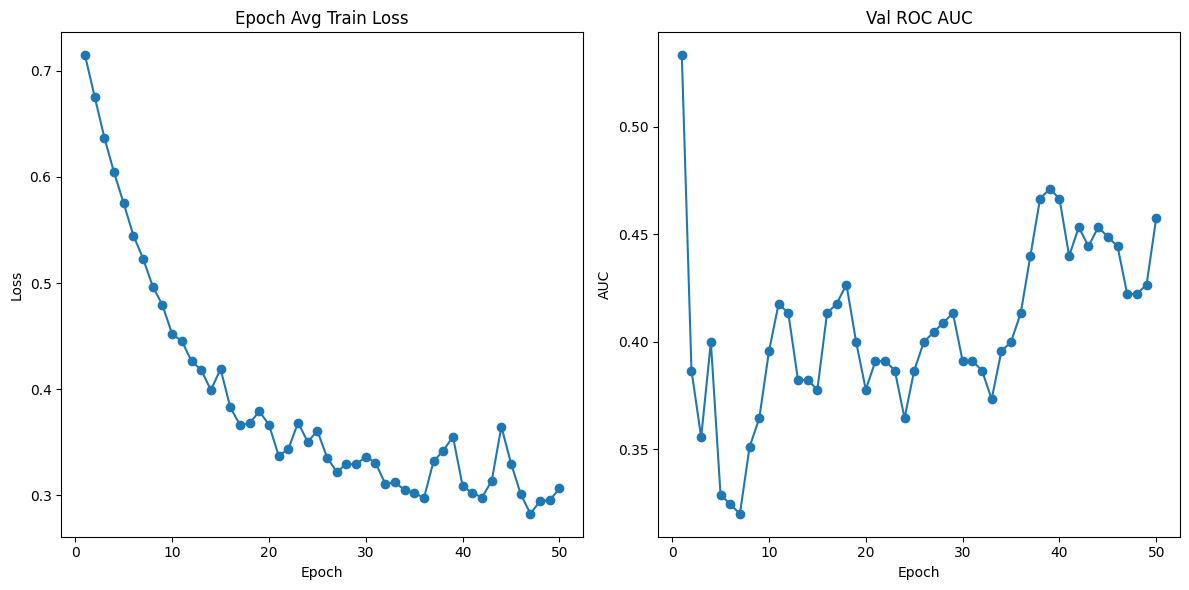

In [ ]:
plt.figure("Training Metrics", (12, 6))

plt.subplot(1, 2, 1)
plt.title("Epoch Avg Train Loss")
plt.plot(np.arange(1, len(epoch_loss_values)+1), epoch_loss_values, marker="o")
plt.xlabel("Epoch"); plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.title("Val ROC AUC")
plt.plot(np.arange(1, len(metric_values)+1), metric_values, marker="o")
plt.xlabel("Epoch"); plt.ylabel("AUC")

plt.tight_layout()
plt.show()

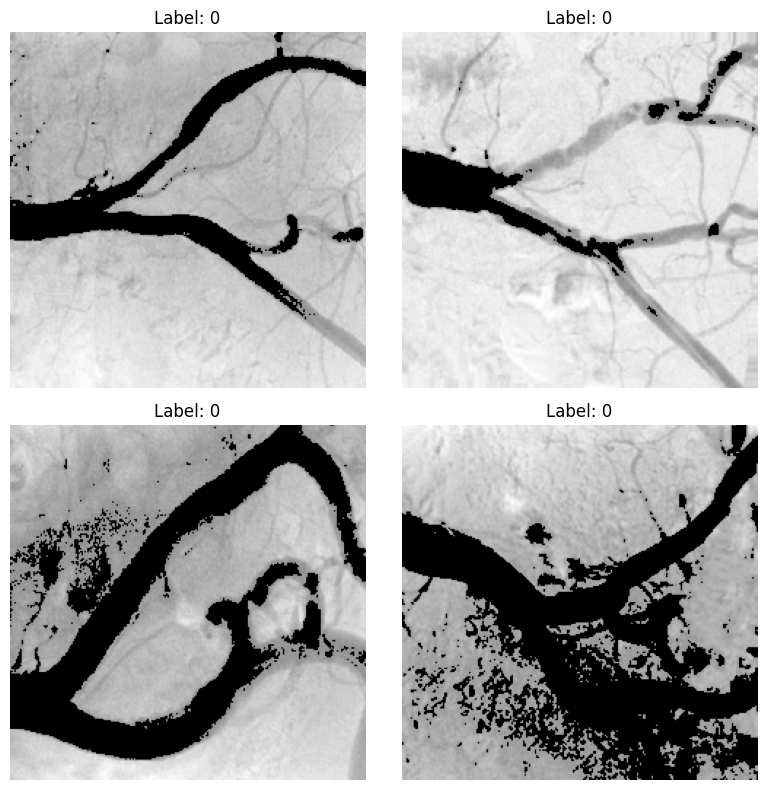

In [ ]:
samples = [train_ds[i] for i in range(4)]  # each is (img_tensor, label)

# Plot in a 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for (img_tensor, label), ax in zip(samples, axes.flat):
    # img_tensor is C×H×W; we selected C=1, so squeeze channel dim
    img = img_tensor.squeeze(0).cpu().numpy()
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis("off")

plt.tight_layout()
plt.show()